In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

2024-07-08 23:27:28.583232: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 23:27:28.619098: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 23:27:30.096920: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 23:27:30.778789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 23:27:31.647186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

# Base

In [20]:
df_ratings = pd.read_csv('corporateCreditRatingWithFinancialRatios.csv')

In [21]:
input_columns = ['Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio',
                 'Gross Margin', 'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
                 'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
                 'ROE - Return On Equity', 'Return On Tangible Equity',
                 'ROA - Return On Assets', 'ROI - Return On Investment',
                 'Operating Cash Flow Per Share', 'Free Cash Flow Per Share']

# *Encoding*

A partir daqui, há uma diferenciação entre dois modelos testados, um com um neurônio na camada de saída (*label encoding*) e um com um neurônio por *rating* (*one hot encoding*).

In [22]:
df_ratings["Rating"] = df_ratings["Rating"].str.replace("+", "").str.replace("-", "")
# rating_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
rating_order = ['D', 'C', 'CC', 'CCC', 'B', 'BB', 'BBB', 'A', 'AA', 'AAA']
df_filtered = df_ratings[df_ratings['Rating'].isin(rating_order)]
number_of_ratings = len(df_filtered['Rating'].unique())

encoder = OrdinalEncoder(categories=[rating_order])
df_ratings['Rating Encoded'] = encoder.fit_transform(df_ratings[['Rating']]).astype(int).flatten()

# Remoção de *outliers* baseado em estudo prévio

In [23]:
method = "Manual"

if method == "IQR":
    # IQR
    Q1 = df_ratings[input_columns].quantile(0.25)
    Q3 = df_ratings[input_columns].quantile(0.75)
    IQR = Q3 - Q1
    print(f"Antes da remoção: {len(df_ratings)}")
    multiplier = 5
    df_ratings = df_ratings[~((df_ratings[input_columns] < (Q1 - multiplier * IQR)) | (df_ratings[input_columns] > (Q3 + multiplier * IQR))).any(axis=1)]
    print(f"Depois da remoção: {len(df_ratings)}")

elif method == "Manual":
    ranges = {
        "Current Ratio": (-5, 20),
        "Long-term Debt / Capital": (-7, 15),
        "Debt/Equity Ratio": (-200, 250),
        "Gross Margin": (-25, 150),
        "Operating Margin": (-250, 100),
        "EBIT Margin": (-200, 100),
        "EBITDA Margin": (-200, 100),
        "Pre-Tax Profit Margin": (-100, 150),
        "Net Profit Margin": (-150, 150),
        "Asset Turnover": (-10, 6),
        "ROE - Return On Equity": (-2500, 2500),
        "Return On Tangible Equity": (-2500, 2500),
        "ROA - Return On Assets": (-100, 80),
        "ROI - Return On Investment": (-250, 250),
        "Operating Cash Flow Per Share": (-80, 100),
        "Free Cash Flow Per Share": (-50, 50)
    }

    for column in input_columns:
        df_ratings.drop(df_ratings[(df_ratings[column] < ranges[column][0]) | (df_ratings[column] > ranges[column][1])].index, inplace=True)

else:
    pass

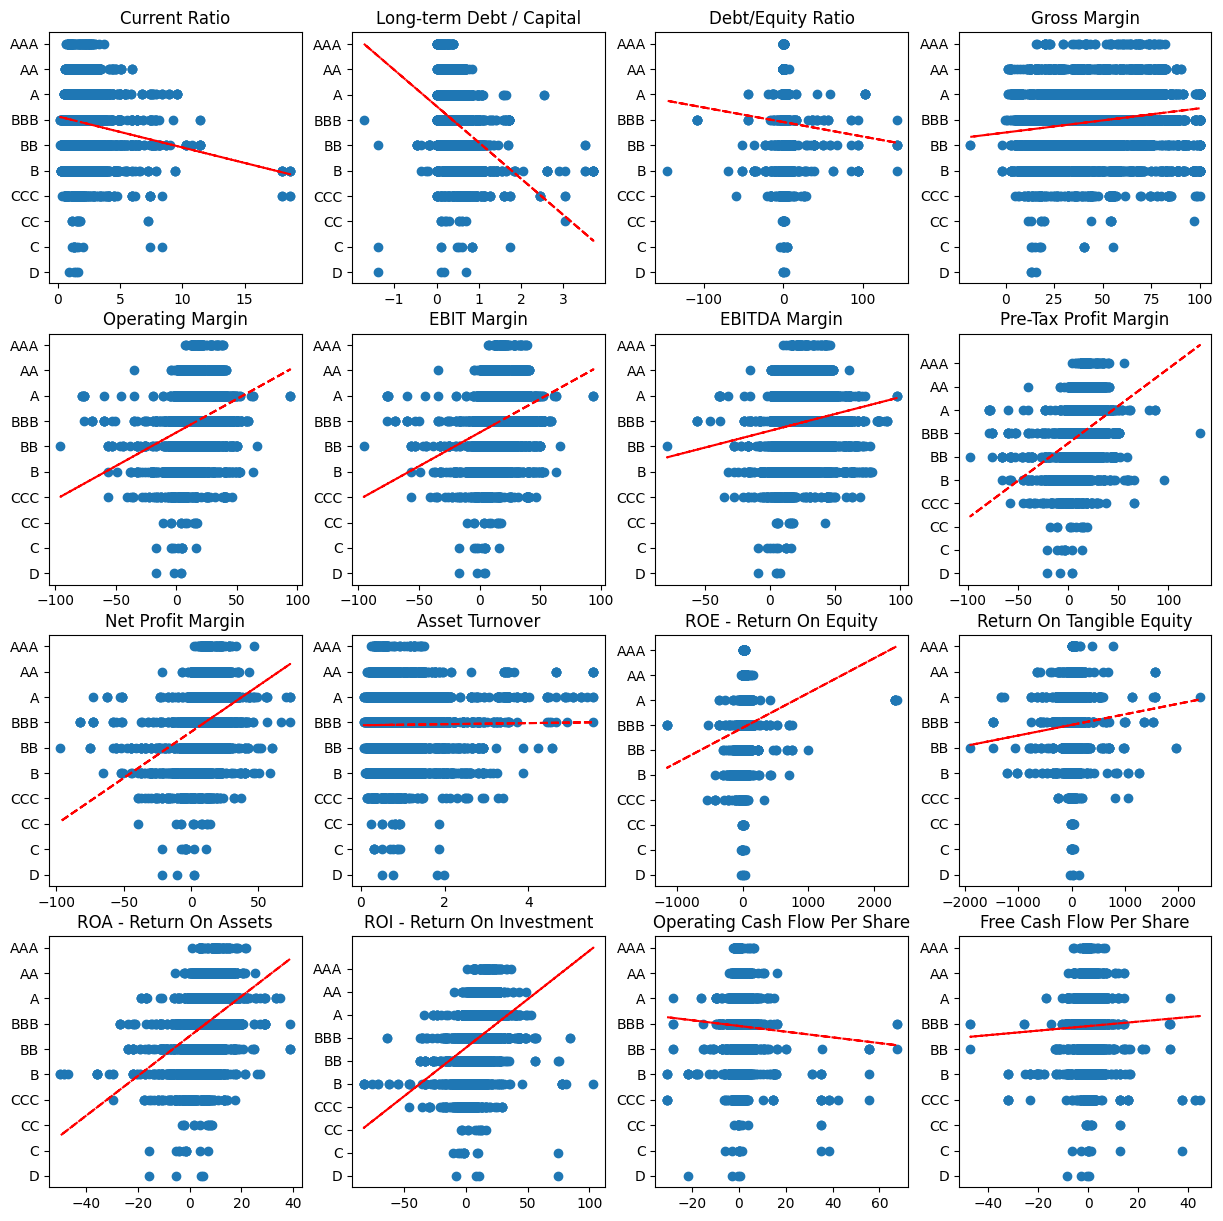

In [24]:
def subplot(ax, col):
    ax.scatter(df_ratings[[col]], df_ratings[['Rating Encoded']])
    coef = np.polyfit(df_ratings[col], df_ratings['Rating Encoded'], 1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(df_ratings[col], poly1d_fn(df_ratings[col]), '--r')
    ax.set_title(col)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

k = 0

for i in range(4):
    for j in range(4):

        ax = plt.subplot2grid((4, 4), (i, j))
        ticks_list = list(range(0, number_of_ratings))
        ax.set_yticks(ticks_list)
        ax.set_yticklabels(rating_order)

        col = input_columns[k]
        subplot(ax, col)
        k += 1

plt.show()

In [25]:
df_relevant = df_ratings[input_columns + ['Rating Encoded']]
correlation_matrix = df_relevant.corr()

# Obter a correlação com a coluna de rating numérico
rating_correlation = correlation_matrix['Rating Encoded'].drop('Rating Encoded')

# Exibir os resultados
print("Correlação entre cada métrica financeira e o rating:")
# print(rating_correlation.sort_values())
df_rating_correlation = rating_correlation.to_frame()
df_rating_correlation['abs(Rating)'] = abs(df_rating_correlation['Rating Encoded'])
df_rating_correlation = df_rating_correlation.sort_values('abs(Rating)', ascending=False).drop(columns=['abs(Rating)'])
df_rating_correlation

Correlação entre cada métrica financeira e o rating:


,Rating Encoded
ROA - Return On Assets,0.364831
Pre-Tax Profit Margin,0.343538
ROI - Return On Investment,0.338599
Long-term Debt / Capital,-0.334174
Net Profit Margin,0.326402
EBIT Margin,0.269066
Operating Margin,0.268002
Gross Margin,0.175628
EBITDA Margin,0.162144
Current Ratio,-0.138441


In [26]:
nro_colunas = int(len(df_rating_correlation) * 0.5)
input_columns = df_rating_correlation.index.tolist()[:nro_colunas]
input_columns

['ROA - Return On Assets',
 'Pre-Tax Profit Margin',
 'ROI - Return On Investment',
 'Long-term Debt / Capital',
 'Net Profit Margin',
 'EBIT Margin',
 'Operating Margin',
 'Gross Margin']

# Normalização

In [27]:
df_ratings[input_columns].describe()

,ROA - Return On Assets,Pre-Tax Profit Margin,ROI - Return On Investment,Long-term Debt / Capital,Net Profit Margin,EBIT Margin,Operating Margin,Gross Margin
count,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000
mean,5.091719,10.581669,8.172018,0.448758,7.631911,13.474776,13.432537,42.520384
std,5.922010,13.641234,10.240836,0.297736,11.449055,12.937800,12.911528,23.453114
min,-49.752600,-97.331300,-82.448400,-1.722800,-97.057100,-95.629500,-95.629500,-18.203900
25%,2.474100,4.195100,3.933600,0.285500,2.886025,6.450575,6.389200,22.631200
50%,4.855300,9.795600,7.522400,0.424800,7.045250,12.373200,12.351650,39.637400
75%,7.928400,16.874850,12.556800,0.534625,12.440800,19.619425,19.570500,59.570000
max,38.823000,131.386900,103.315200,3.712900,73.607800,93.993000,93.993000,100.000000


In [28]:
df_train = df_ratings[input_columns].copy().reset_index(drop=True)
df_train.iloc[:, 0:-1] = StandardScaler().fit_transform(df_train.iloc[:, 0:-1].to_numpy())
# df_train.iloc[:, 0:-1] = MinMaxScaler().fit_transform(df_train.iloc[:, 0:-1].to_numpy())

In [29]:
df_train.describe()

,ROA - Return On Assets,Pre-Tax Profit Margin,ROI - Return On Investment,Long-term Debt / Capital,Net Profit Margin,EBIT Margin,Operating Margin,Gross Margin
count,7.620000e+03,7.620000e+03,7.620000e+03,7.620000e+03,7.620000e+03,7.620000e+03,7.620000e+03,7620.000000
mean,1.156264e-16,1.268160e-16,-3.729883e-17,7.459766e-17,7.459766e-18,6.713790e-17,-6.713790e-17,42.520384
std,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,23.453114
min,-9.261707e+00,-7.911312e+00,-8.849509e+00,-7.294045e+00,-9.144500e+00,-8.433539e+00,-8.447427e+00,-18.203900
25%,-4.420444e-01,-4.682119e-01,-4.139014e-01,-5.483684e-01,-4.145493e-01,-5.429565e-01,-5.455434e-01,22.631200
50%,-3.992476e-02,-5.762828e-02,-6.343823e-02,-8.047380e-02,-5.124437e-02,-8.514961e-02,-8.372038e-02,39.637400
75%,4.790378e-01,4.613654e-01,4.281945e-01,2.884173e-01,4.200525e-01,4.749689e-01,4.754175e-01,59.570000
max,5.696292e+00,8.856469e+00,9.291178e+00,1.096392e+01,5.762940e+00,6.223895e+00,6.239831e+00,100.000000


# Amostras de treino e de teste

In [59]:
X = df_train[input_columns].copy()

y = df_ratings['Rating Encoded']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

# Treinamento

In [61]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(number_of_ratings, activation='softmax')
])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose = 0)

y_predict = model.predict(X_test)
y_predict = np.argmax(y_predict, axis=1)

/home/cmore/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


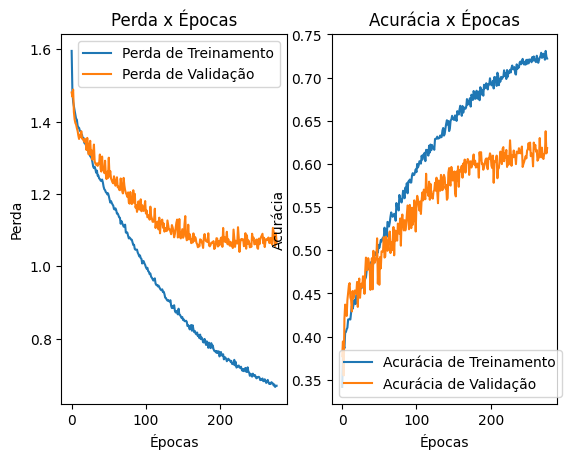

In [62]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda x Épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia x Épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

# Resultados

In [63]:
y_predict = model.predict(X_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [64]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6328 - loss: 1.0191
Test accuracy: 0.6273


In [65]:
predictions = np.argmax(y_predict, axis=1)
actuals = np.asarray(y_test.tolist())

# Decodificar os valores numéricos de volta para os rótulos originais
ratings = encoder.inverse_transform(predictions.reshape(-1, 1))
actual_ratings = encoder.inverse_transform(actuals.reshape(-1, 1))

# Criar um DataFrame com as previsões e os valores reais
df_comparison = pd.DataFrame({'Previsão': ratings.flatten(), 'Real': actual_ratings.flatten()})

# Mostrar até 100 registros
print(df_comparison.head(100))

   Previsão Real
0        BB   BB
1       BBB  BBB
2        BB   BB
3       BBB  BBB
4        BB  BBB
..      ...  ...
95       AA   AA
96        A    A
97        A    A
98      BBB    A
99        B    B

[100 rows x 2 columns]


In [ ]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(128, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(number_of_ratings, activation='softmax')
    ])
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose = 0)

    y_predict = model.predict(X_test)
    y_predict = np.argmax(y_predict, axis=1)

    y_predict = model.predict(X_test)

    loss, accuracy = model.evaluate(X_test, y_test)

    f = open('test_results.txt', 'a')
    f.write(f"| {i} | {accuracy:.4f}\n")
    f.close()